In [61]:
!pip install -U sentence-transformers
!pip install pyLDAvis
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.5 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=c6696fe7125b59bbba5b82ea99e3df39da5445ce6ee7dc862a5b34a6d8d98622
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://u

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.1 MB/s eta 0:00:00


In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count

In [3]:
clinical_text_df = pd.read_csv("/content/ICD10-13.csv")

print(clinical_text_df.columns)
clinical_text_df.head(5)

Index(['labels', 'notes', 'code', 'paraphrase'], dtype='object')


,labels,notes,code,paraphrase
0,Arthropathies,The patient presents with severe arthropathies...,M00-M25,"The individual exhibits intense joint issues, ..."
1,Arthropathies,The patient exhibits arthropathies with sympto...,M00-M25,The individual demonstrates joint problems cha...
2,Arthropathies,The patient exhibits symptoms of arthropathies...,M00-M25,The individual presents with indications of ar...
3,Arthropathies,"The patient has arthropathies, which manifest ...",M00-M25,The individual experiences arthropathies chara...
4,Arthropathies,"The patient displays signs of arthropathies, i...",M00-M25,The individual exhibits symptoms of arthropath...


In [4]:
clinical_text_df = clinical_text_df[clinical_text_df['notes'].notna()]
sent_count,word_count= get_sentence_word_count(clinical_text_df['notes'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))



data_categories  = clinical_text_df.groupby(clinical_text_df['code'])
i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')

Number of sentences in transcriptions column: 1660
Number of unique words in transcriptions column: 1684
===========Original Categories =======================
Cat:1 M00-M25 : 52
Cat:2 M26-M27 : 62
Cat:3 M30-M36 : 61
Cat:4 M40-M54 : 64
Cat:5 M60-M79 : 59
Cat:6 M80-M94 : 50
Cat:7 M95-M99 : 81


In [5]:
import nlpaug.augmenter.word as naw

def augment_text(text):
    # Using synonym augmentation
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_text = aug.augment(text)
    return augmented_text[0]


t = """
Adult Osteomalacia and Medication-Induced Deficiency: 
Patient exhibits bone pain and is on long-term medication associated with vitamin D deficiency. 
Conduct evaluation to assess medication-induced osteomalacia. Collaborate with prescribing physicians for medication review and dose adjustment 
if necessary. Initiate appropriate vitamin D supplementation and monitor progress regularly.
"""

augmented_note = augment_text(t)
print(augmented_note)
print(f"Are the text equal: {augmented_note == t}")


Adult Osteomalacia and Medication - Induced Deficiency: Patient exhibits bone pain and is on longsighted - term medication associate with vitamin D insufficiency. Conduct evaluation to assess medication - induced osteomalacia. Collaborate with prescribing physicians for medicine review and dose adjustment if necessary. Tiro appropriate vitamin D supplementation and monitor procession regularly.
Are the text equal: False


In [98]:
augmented_note

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Adult Osteomalacia and Medication - Induced Deficiency: Patient exhibits bone pain and is on longsighted - term medication associate with vitamin D insufficiency. Conduct evaluation to assess medication - induced osteomalacia. Collaborate with prescribing physicians for medicine review and dose adjustment if necessary. Tiro appropriate vitamin D supplementation and monitor procession regularly.'

In [6]:
df = clinical_text_df.copy()
df["aug_text"] = df.notes.apply(augment_text)
df["aug_paraphrase"] = df.paraphrase.apply(augment_text)
df.head()

,labels,notes,code,paraphrase,aug_text,aug_paraphrase
0,Arthropathies,The patient presents with severe arthropathies...,M00-M25,"The individual exhibits intense joint issues, ...","The patient presents with severe arthropathy, ...","The single exhibits intense joint issues, mark..."
1,Arthropathies,The patient exhibits arthropathies with sympto...,M00-M25,The individual demonstrates joint problems cha...,The patient exhibits arthropathies with sympto...,The individual demonstrates joint problems cha...
2,Arthropathies,The patient exhibits symptoms of arthropathies...,M00-M25,The individual presents with indications of ar...,"The patient show symptoms of arthropathies, wi...",The individual present with indications of art...
3,Arthropathies,"The patient has arthropathies, which manifest ...",M00-M25,The individual experiences arthropathies chara...,"The patient role has arthropathies, which mani...",The individual experiences arthropathies chara...
4,Arthropathies,"The patient displays signs of arthropathies, i...",M00-M25,The individual exhibits symptoms of arthropath...,"The patient displays sign of arthropathies, in...",The individual exhibits symptoms of arthropath...


In [7]:
def clean_text(text ): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist) 

In [8]:
df = df.sample(frac=1, random_state=23)

df['notes'] = df['notes'].apply(lemmatize_text)
df['notes'] = df['notes'].apply(clean_text)

df['aug_text'] = df['aug_text'].apply(lemmatize_text)
df['aug_text'] = df['aug_text'].apply(clean_text)

df['paraphrase'] = df['paraphrase'].apply(lemmatize_text)
df['paraphrase'] = df['paraphrase'].apply(clean_text)

In [9]:
p1, p2, p3 = df[['notes', 'code', 'labels']], df[['aug_text', 'code', 'labels']], df[['aug_paraphrase', 'code', 'labels']]
p1.columns = ['notes', 'codes', 'labels']
p2.columns = ['notes', 'codes', 'labels']
p3.columns = ['notes', 'codes', 'labels']

aug_df = pd.concat([p1, p2, p3], axis=0, ignore_index=True)
aug_df = aug_df[['notes', 'codes', 'labels']]
aug_df = aug_df.sample(frac=1)
print(f"Size: {len(aug_df)}")
aug_df.head()

Size: 1287


,notes,codes,labels
341,dorsopathies and postural imbalance patient e...,M40-M54,Dorsopathies
722,deforming dorsopathies and annoyance managemen...,M40-M54,Dorsopathies
444,takayasu arteritis patient present with necro...,M30-M36,Systemic connective tissue disorders
215,myositis assessment patient exhibit muscle in...,M60-M79,Soft tissue disorders
586,polyarteritis nodosa remission patient with a...,M30-M36,Systemic connective tissue disorders


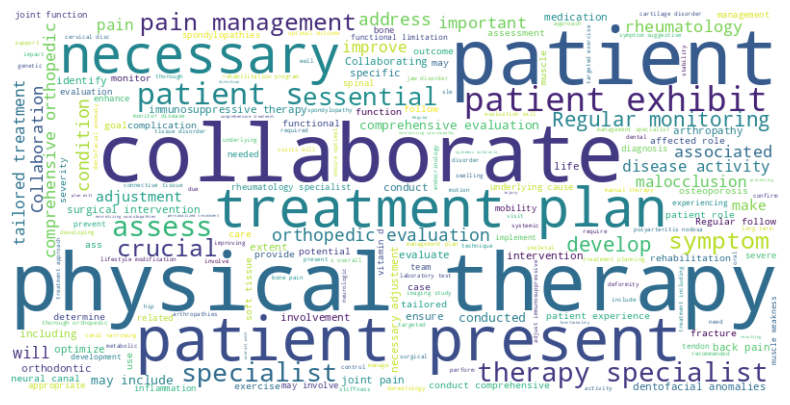

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Example text dataset
text = ' '.join(aug_df['notes'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


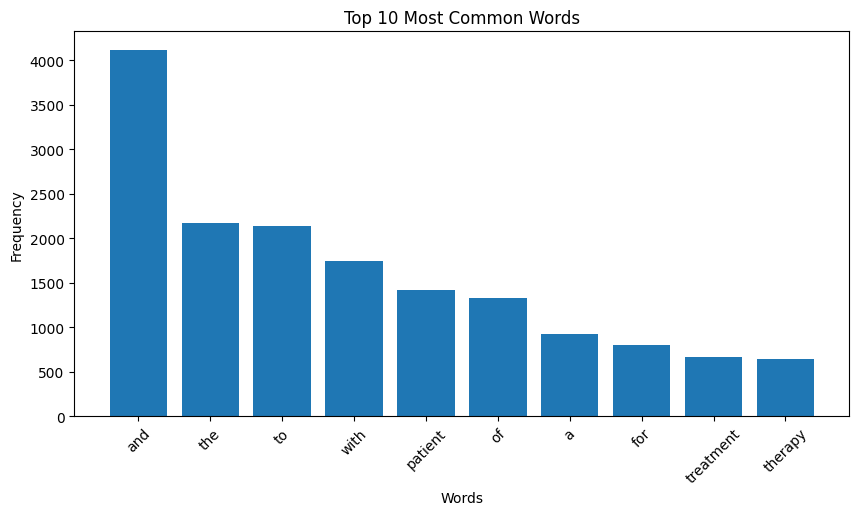

In [11]:
from collections import Counter

# Concatenate all text entries into a single string
text = ' '.join(aug_df['notes'])

# Tokenize the text into individual words
tokens = text.split()

# Count the frequency of each word
word_counts = Counter(tokens)

# Get the most common words and their frequencies
top_words = word_counts.most_common(10)  # Change the number to display more or fewer words

# Extract the words and frequencies
words, frequencies = zip(*top_words)

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45)
plt.show()

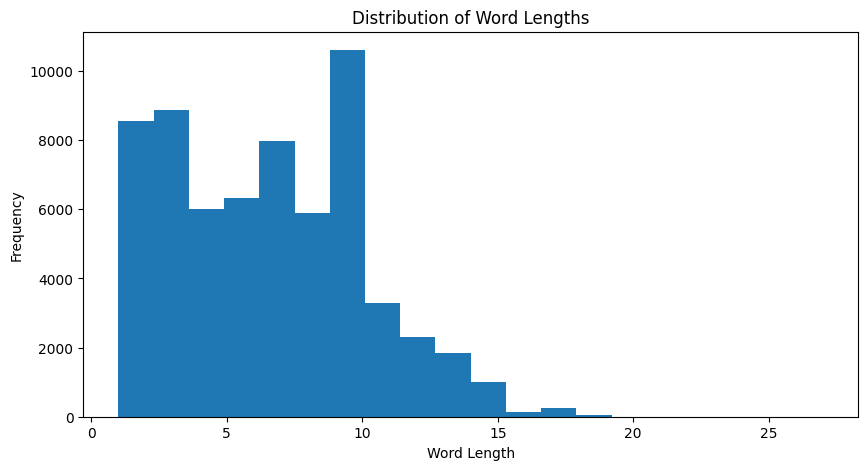

In [12]:
# Concatenate all text entries into a single string
text = ' '.join(aug_df['notes'])

# Tokenize the text into individual words
tokens = text.split()

# Calculate the length of each word
word_lengths = [len(word) for word in tokens]

# Create a histogram
plt.figure(figsize=(10, 5))
plt.hist(word_lengths, bins=20)
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Word Lengths')
plt.show()


In [13]:
import pyLDAvis.gensim_models
from gensim import models
from gensim.corpora import Dictionary
import pyLDAvis.gensim

# Concatenate all text entries into a single string
text = ' '.join(aug_df['notes'])

# Tokenize the text into individual words
tokens = nltk.word_tokenize(text)

# Create a Gensim Dictionary
dictionary = Dictionary([tokens])

# Create a Gensim Corpus
corpus = [dictionary.doc2bow(tokens)]

# Define the number of topics for LDA
num_topics = 5

# Create and fit the LDA model
lda_model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, random_state=42)

# Visualize the topics
vis_data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)


In [65]:
df = aug_df[:1200]
test = aug_df[1200:]

vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), 
                             max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(df['notes'].tolist())
feature_names = sorted(vectorizer.get_feature_names_out())
print(f"Feature names or Tokens: {feature_names}")
print(f"Data shape{tfIdfMat.shape}")

pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = df['codes'].tolist()
category_list = df.codes.unique()



X_temp, X_test, y_temp, y_test = train_test_split(tfIdfMat_reduced, labels, 
                                                    test_size=0.2, stratify=labels,random_state=1)
   
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=23)

print(X_train.shape, X_val.shape, X_test.shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Feature names or Tokens: ['abnormal', 'abnormalities', 'abnormality', 'abnormality collaborate', 'accordingly', 'achieve', 'achieve optimal', 'acquired', 'acquired neck', 'acquired neck deformity', 'activities', 'activity', 'activity adjust', 'activity minimize', 'acute', 'additionally', 'address', 'address malocclusion', 'address specific', 'addresses', 'addressing', 'adjust', 'adjust immunosuppressive', 'adjust immunosuppressive therapy', 'adjust treatment', 'adjustment', 'adjustments', 'adjustments treatment', 'adjustments treatment plan', 'adult', 'adult osteomalacia', 'advanced', 'aesthetic', 'affected', 'affected role', 'affecting', 'age', 'age related', 'aim', 'airway', 'alignment', 'alleviate', 'alleviate pain', 'alleviate symptoms', 'allow', 'anomalies', 'anomalies patient', 'anomaly', 'anti', 'anti inflammatory', 'antirheumatic', 'approach', 'appropriate', 'appropriate treatment', 'arm', 'arm therapy', 'arteritis', 'arthritis', 'arthropathic', 'arthropathies', 'arthropathy', 

In [66]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', 
                         l1_ratio=0.5, max_iter=150, random_state=23).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


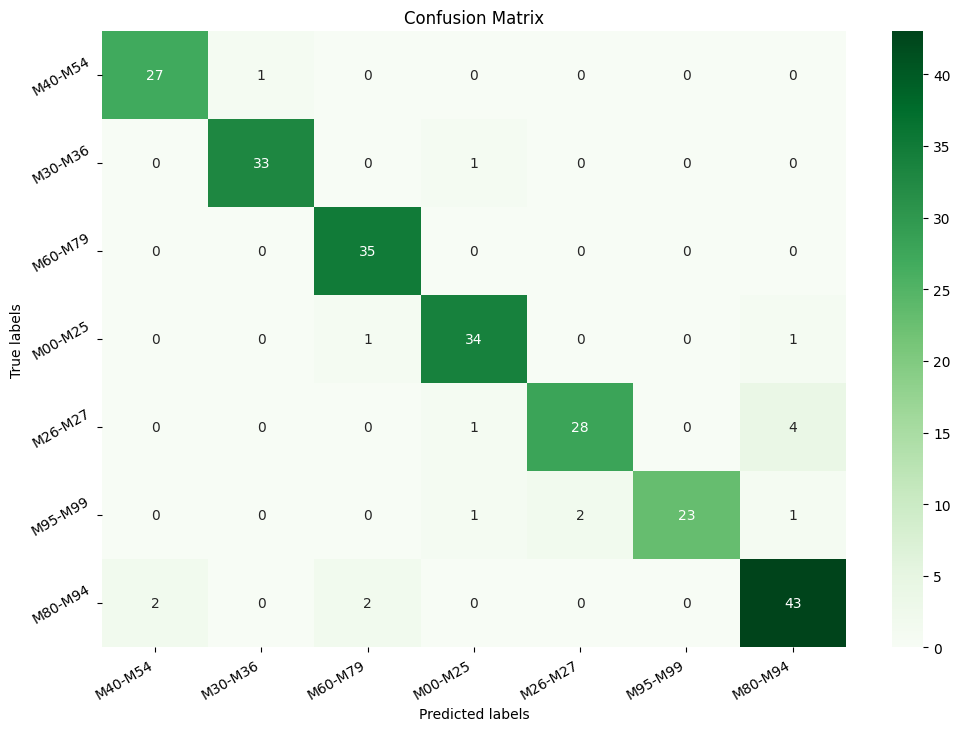

In [68]:
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

In [69]:
print(classification_report(y_test,y_test_pred,labels=category_list))

              precision    recall  f1-score   support

     M40-M54       0.92      0.94      0.93        36
     M30-M36       0.92      1.00      0.96        35
     M60-M79       0.93      0.85      0.89        33
     M00-M25       0.93      0.96      0.95        28
     M26-M27       0.97      0.97      0.97        34
     M95-M99       0.88      0.91      0.90        47
     M80-M94       1.00      0.85      0.92        27

    accuracy                           0.93       240
   macro avg       0.94      0.93      0.93       240
weighted avg       0.93      0.93      0.93       240



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
clf.predict(X_val[:3]) == y_val[:3]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ True,  True,  True])

## Inference

In [72]:
test.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,notes,codes,labels
1282,Patient with chronic back pain and limited spi...,M40-M54,Dorsopathies
78,dorsopathies rehabilitation patient with chro...,M40-M54,Dorsopathies
184,pregnancy in systemic lupus erythematosus sle...,M30-M36,Systemic connective tissue disorders
573,progressive deforming dorsopathies patient wi...,M40-M54,Dorsopathies
16,patient with longstanding malocclusion and tem...,M26-M27,Dentofacial anomalies [including malocclusion]...


In [79]:
test['notes'] = test['notes'].apply(lemmatize_text)
test['notes'] = test['notes'].apply(clean_text)

representations = vectorizer.transform(test['notes'].tolist())
x = pca.transform(representations.toarray())
print(f"Prediction: {clf.predict(x)[0]}")
print(f"Ground Truth: {test['codes'].iloc[0]}")

Prediction: M40-M54
Ground Truth: M40-M54


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Random Forest

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [81]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Best Score: 0.9263888888888889


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


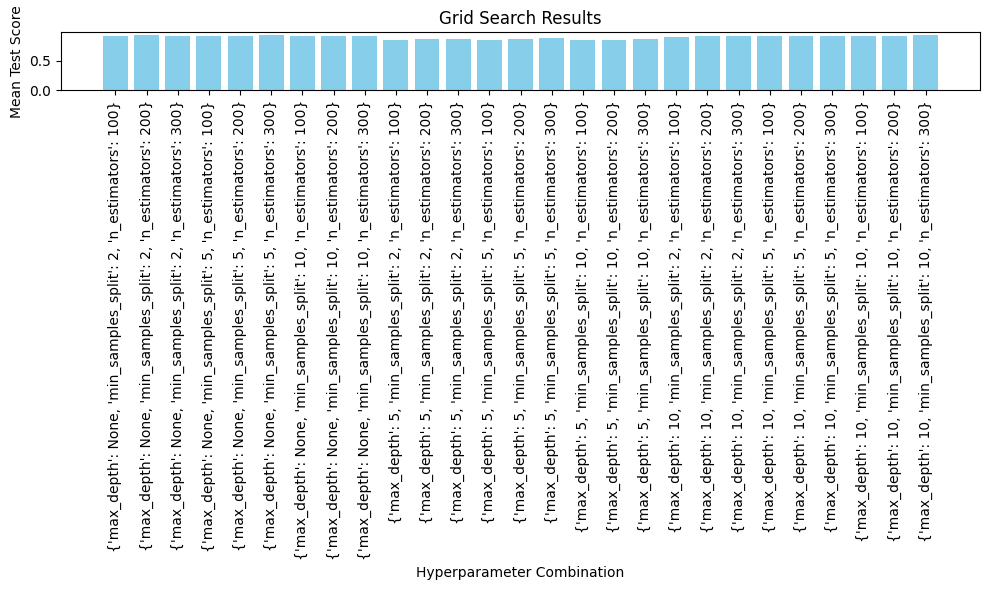

In [82]:
param_values = []
mean_scores = []
for params, mean_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    param_values.append(str(params))
    mean_scores.append(mean_score)

# Create a bar plot to visualize the mean scores for each hyperparameter combination
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(mean_scores)), mean_scores, align='center', color='skyblue')
plt.xticks(np.arange(len(mean_scores)), param_values, rotation=90)
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Results')
plt.tight_layout()
plt.show()

In [83]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=None, min_samples_split=5, n_estimators=300)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


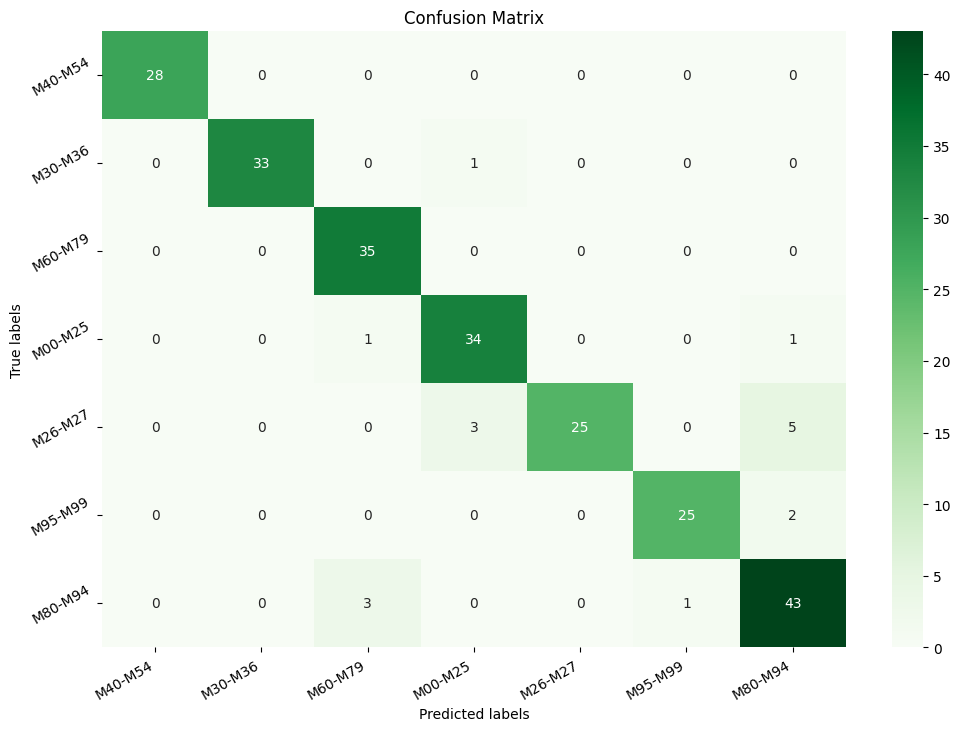

In [84]:
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

In [85]:
print(classification_report(y_test,y_test_pred,labels=category_list))

              precision    recall  f1-score   support

     M40-M54       0.89      0.94      0.92        36
     M30-M36       0.90      1.00      0.95        35
     M60-M79       1.00      0.76      0.86        33
     M00-M25       1.00      1.00      1.00        28
     M26-M27       1.00      0.97      0.99        34
     M95-M99       0.84      0.91      0.88        47
     M80-M94       0.96      0.93      0.94        27

    accuracy                           0.93       240
   macro avg       0.94      0.93      0.93       240
weighted avg       0.93      0.93      0.93       240



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Inference

In [86]:
inp = """

A patient is presenting with keloid formation, a fibroblastic disorder characterized by excessive scar tissue formation. 
To properly assess and manage this condition, a comprehensive dermatologic examination will be performed. 
This examination will evaluate the extent of keloids and any associated symptoms. 
Collaboration with plastic surgery specialists will be necessary to develop a customized treatment plan. 
Treatment options may include surgical excision, corticosteroid injections to reduce inflammation, 
and adjuvant therapies such as pressure therapy or silicone sheets. 
Regular follow-up visits will be important to monitor the progress of the treatment 
and make any necessary adjustments to optimize outcomes.

"""
new_row = {'notes': [inp], 
           'codes': ['M60-M79']}

new_df = pd.DataFrame(new_row)

new_df['notes'] = new_df['notes'].apply(lemmatize_text)
new_df['notes'] = new_df['notes'].apply(clean_text)

representations = vectorizer.transform(new_df['notes'].tolist())
x = pca.transform(representations.toarray())
print(f"Prediction: {clf.predict(x)[0]}")
print(f"Ground Truth: {new_df['codes'][0]}")

Prediction: M60-M79
Ground Truth: M60-M79


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
test['notes'] = test['notes'].apply(lemmatize_text)
test['notes'] = test['notes'].apply(clean_text)

representations = vectorizer.transform(test['notes'].tolist())
x = pca.transform(representations.toarray())
print(f"Prediction: {clf.predict(x)[45]}")
print(f"Ground Truth: {test['codes'].iloc[45]}")

Prediction: M00-M25
Ground Truth: M00-M25


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
test.iloc[45].notes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'patient urgently present with arthropathy exhibiting rapidly progressing joint inflammation severe pain and limited mobility immediate comprehensive evaluation needed including laboratory test imaging and consultation with rheumatology and infectious disease specialist'